# Notebook 03: Classification Model

**Student Name:** Erick Lanford

**Dataset:** Md Vessel jobs

**Original Target Variable:** [Your Original Numerical Target]

**Binned Target Variable:** [Your Categorical Target - e.g., Low/Medium/High]

**Checkpoint 4 Due:** Feb 22

---

## Rules & Integrity

1. **NO AI TOOLS**: You may **NOT** use ChatGPT, Claude, Gemini, GitHub Copilot, or any other AI assistant to generate code for this assignment. The goal is to build *your* fundamental skills. If you rely on AI now, the advanced topics later will be impossible.

2. **Study Groups Encouraged**: You **ARE** encouraged to discuss ideas, share approaches, and explain concepts to your study group peers. Teaching others is the best way to learn! However, the code you submit must be **your own work**.

3. **Use Your Resources**: You are free to use Google, StackOverflow, Pandas/Scikit-learn documentation, and your class notes.

4. **Comment Your Code**: Include comments explaining *why* you're doing what you're doing. I want to see your thought process.

5. **Resubmission**: You may submit this assignment multiple times for feedback before the checkpoint deadline.

---

## Important: Written Reflections

Throughout this notebook, you'll be asked to interpret results, justify decisions, and explain your reasoning. **These written reflections are a critical part of your grade.**

Your binning justification, model selection reasoning, and analysis of the confusion matrix demonstrate your understanding. These reflections are what employers look for—the ability to communicate technical decisions clearly.

---

## Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Sklearn - evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Model saving
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 1: Load Processed Data

In [6]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')

print(f"Data shape: {df.shape}")
df.head()

Data shape: (4654, 19)


,Depth,DraftNumeric,DurationMinutes,WL_CBBT_Chesapeake_Channel_VA,WL_CBBT_Chesapeake_Channel_VA_speed,WL_Windmill_Point_VA,WL_Windmill_Point_VA_speed,WL_Annapolis_MD,WL_Annapolis_MD_speed,CUR_Rappahannock_Shoal_Channel_speed,CUR_Rappahannock_Shoal_Channel_direction,CUR_York_Spit_LB_22_speed,CUR_York_Spit_LB_22_direction,CUR_Chesapeake_City_speed,CUR_Chesapeake_City_direction,RouteIndex,VesselTypeREF_encoded,Propulsion_encoded,Direction_encoded
0,21.30,29.91667,139,0.717,0.021,0.424,0.004,0.349,0.007,0.313,318.0,1.530,351.0,0.511,91.0,0,3,1,4
1,24.80,31.16667,612,0.597,0.024,0.452,0.003,0.320,0.004,0.500,346.0,1.322,356.0,0.076,96.0,1,6,1,1
2,13.30,31.49606,323,0.367,0.028,0.319,0.003,0.506,0.004,0.148,180.0,0.330,122.0,0.426,270.0,2,11,3,5
3,13.30,27.88714,756,0.367,0.028,0.319,0.003,0.506,0.004,0.148,180.0,0.334,135.0,0.332,274.0,3,11,3,1
4,32.09,27.23097,484,0.503,0.032,0.306,0.001,0.538,0.002,0.301,167.0,0.301,144.0,0.136,109.0,4,21,1,1


In [7]:
# Define your original target variable
ORIGINAL_TARGET = 'DurationMinutes'  # <-- UPDATE THIS

print(f"Original Target: {ORIGINAL_TARGET}")
print(f"\nTarget statistics:")
print(df[ORIGINAL_TARGET].describe())

Original Target: DurationMinutes

Target statistics:
count    4654.000000
mean      520.713150
std       244.001448
min        30.000000
25%       300.000000
50%       586.000000
75%       670.000000
max      1450.000000
Name: DurationMinutes, dtype: float64


## Section 2: Create Binned Target

Convert your regression target into classification categories.

### 2.1 Binning Strategy Justification

**Your approved binning strategy:**

- **Number of categories:** [3]
- **Category names:** [Short trips, Medium trips, Long trips]
- **Thresholds:** [Short trips: ≤ 360 minutes, Medium trips: 360 – 660 minutes, Long trips: > 660 minutes]

**Why this makes sense for your problem:**

The proposed binning strategy creates three categories: Short trips, Medium trips, and Long trips. 
The thresholds are chosen based on the distribution of the target variable (DurationMinutes) to ensure that each category has a meaningful number of observations.

In [8]:
# View the distribution before binning
print("Target distribution:")
print(f"Min: {df[ORIGINAL_TARGET].min():.2f}")
print(f"25th percentile: {df[ORIGINAL_TARGET].quantile(0.25):.2f}")
print(f"Median: {df[ORIGINAL_TARGET].median():.2f}")
print(f"75th percentile: {df[ORIGINAL_TARGET].quantile(0.75):.2f}")
print(f"Max: {df[ORIGINAL_TARGET].max():.2f}")

Target distribution:
Min: 30.00
25th percentile: 300.00
Median: 586.00
75th percentile: 670.00
Max: 1450.00


In [9]:
# TODO: Create your binned target using YOUR approved binning strategy
#
# Steps:
# 1. Define your bin edges (e.g., bins = [min-1, threshold1, threshold2, max+1])
# 2. Define your category labels (e.g., labels = ['Low', 'Medium', 'High'])
# 3. Use pd.cut() to create the binned column
#
# Example:
# bins = [df[ORIGINAL_TARGET].min()-1, 50000, 100000, df[ORIGINAL_TARGET].max()+1]
# labels = ['Low', 'Medium', 'High']
# df['target_category'] = pd.cut(df[ORIGINAL_TARGET], bins=bins, labels=labels)

# YOUR CODE HERE:
bins = [df[ORIGINAL_TARGET].min()-1, 360, 660, df[ORIGINAL_TARGET].max()+1]  # Define your bin edges
labels = ['Short', 'Medium', 'Long']  # Define your category names

df['target_category'] = pd.cut(df[ORIGINAL_TARGET], bins=bins, labels=labels)

print("Binned target distribution:")
print(df['target_category'].value_counts())

Binned target distribution:
target_category
Medium    2088
Short     1312
Long      1254
Name: count, dtype: int64


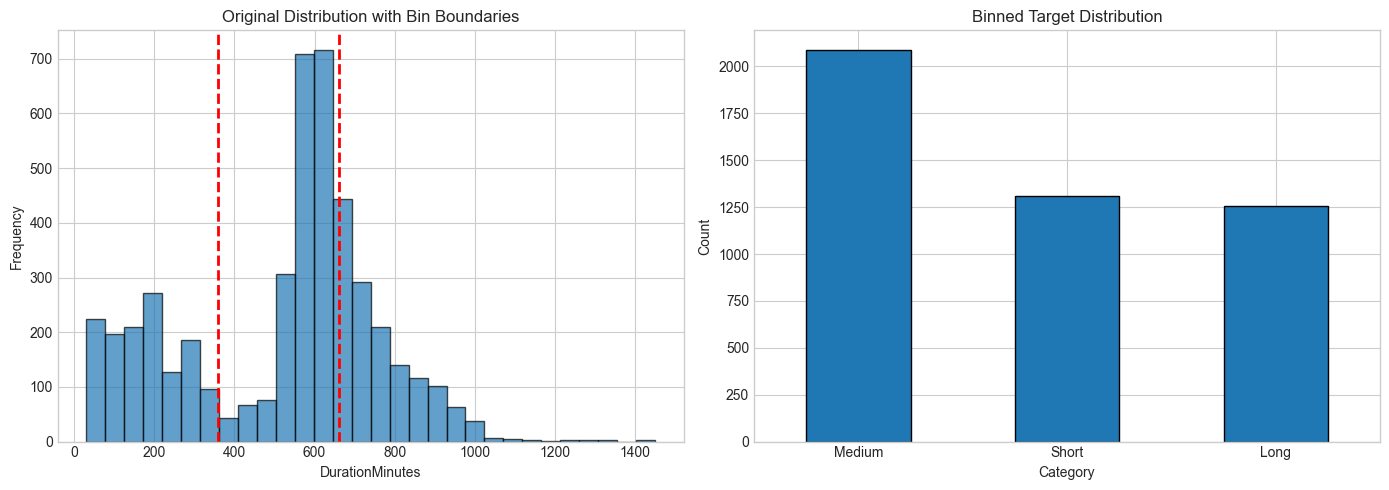

In [10]:
# Visualize the binned distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution with bin lines
axes[0].hist(df[ORIGINAL_TARGET], bins=30, edgecolor='black', alpha=0.7)
for edge in bins[1:-1]:  # Skip first and last (min/max)
    axes[0].axvline(edge, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel(ORIGINAL_TARGET)
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Distribution with Bin Boundaries')

# Binned category counts
df['target_category'].value_counts().plot(kind='bar', ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Binned Target Distribution')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 2.2 Check Class Balance

*Is your binned target reasonably balanced?*

In [11]:
# Check class balance
class_counts = df['target_category'].value_counts()
class_percentages = df['target_category'].value_counts(normalize=True) * 100

print("Class Distribution:")
for cat in class_counts.index:
    print(f"{cat}: {class_counts[cat]} ({class_percentages[cat]:.1f}%)")

# Check for severe imbalance
min_class_pct = class_percentages.min()
if min_class_pct < 10:
    print(f"\nWarning: Smallest class is only {min_class_pct:.1f}% of data.")
    print("Consider adjusting your binning strategy.")
else:
    print(f"\nClass balance looks reasonable!")

Class Distribution:
Medium: 2088 (44.9%)
Short: 1312 (28.2%)
Long: 1254 (26.9%)

Class balance looks reasonable!


## Section 3: Feature Consistency Check

**Important:** For consistency, you should use the same features for classification as you did for regression. This makes your app simpler (users enter the same inputs for both models) and allows for fair comparison.

If you decide to use different features, provide a strong justification below.

In [12]:
# Load the features you selected in the regression notebook
try:
    regression_features = joblib.load('../models/regression_features.pkl')
    print("Features from Regression Model:")
    print(regression_features)
    print(f"\nNumber of regression features: {len(regression_features)}")
except FileNotFoundError:
    print("Warning: regression_features.pkl not found!")
    print("Make sure you've completed Notebook 02 and saved your regression model first.")
    regression_features = None

Features from Regression Model:
['RouteIndex', 'Direction_encoded', 'DraftNumeric', 'Depth', 'VesselTypeREF_encoded', 'Propulsion_encoded', 'WL_Annapolis_MD_speed', 'CUR_York_Spit_LB_22_direction']

Number of regression features: 8


### Feature Selection Decision

**Will you use the same features as your regression model?**

- [X] **Yes, same features** (Recommended for simpler deployment)
- [ ] **No, different features** (Requires justification below)

**If using different features, justify why:**

[Write your justification here - e.g., "For classification, feature X is less predictive of categories than it was for the continuous target..."]

In [13]:
# DECIDE: Use regression features or define new ones?

# Option A: Use the same features as regression (RECOMMENDED)
if regression_features is not None:
    SELECTED_FEATURES = regression_features
    print("Using same features as regression model.")
else:
    # Option B: Define your own features (if regression not done yet)
    SELECTED_FEATURES = [
        # 'feature1',
        # 'feature2',
        # 'feature3',
        # etc.
    ]
    print("Defining features manually.")

print(f"\nSelected features for classification ({len(SELECTED_FEATURES)}):")
for i, f in enumerate(SELECTED_FEATURES, 1):
    print(f"  {i}. {f}")

Using same features as regression model.

Selected features for classification (8):
  1. RouteIndex
  2. Direction_encoded
  3. DraftNumeric
  4. Depth
  5. VesselTypeREF_encoded
  6. Propulsion_encoded
  7. WL_Annapolis_MD_speed
  8. CUR_York_Spit_LB_22_direction


## Section 4: Prepare Features and Target

In [14]:
# Create feature matrix using SELECTED features
X = df[SELECTED_FEATURES].copy()
y = df['target_category']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()}")
print(f"\nTarget classes: {y.unique().tolist()}")

Features shape: (4654, 8)
Target shape: (4654,)

Features used: ['RouteIndex', 'Direction_encoded', 'DraftNumeric', 'Depth', 'VesselTypeREF_encoded', 'Propulsion_encoded', 'WL_Annapolis_MD_speed', 'CUR_York_Spit_LB_22_direction']

Target classes: ['Short', 'Medium', 'Long']


### 4.1 Label Encoding

Many sklearn models require numeric targets. Use LabelEncoder to convert category names to numbers.

In [15]:
# TODO: Encode your target labels to numbers using LabelEncoder
#
# Steps:
# 1. Create a LabelEncoder instance
# 2. Fit and transform y to create y_encoded
#
# Hint: label_encoder.fit_transform(y)

# YOUR CODE HERE:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['target_category'])


In [16]:
# Verify encoding (run this to check)
print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Label encoding:
Long -> 0
Medium -> 1
Short -> 2


## Section 5: Train-Test Split

For classification, we use **stratified** splitting to ensure each class is proportionally represented in both train and test sets.

In [17]:
# TODO: Split your data with stratification
#
# Requirements:
# - 80/20 split (test_size=0.2)
# - random_state=42 for reproducibility
# - stratify=y_encoded (THIS IS THE KEY DIFFERENCE FROM REGRESSION!)
#   This ensures each class is proportionally represented in train/test
#
# Store in: X_train, X_test, y_train, y_test

# YOUR CODE HERE:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [18]:
# Verify split and stratification
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Training set: 3723 samples
Test set: 931 samples

Training class distribution:
  Long: 1003 (26.9%)
  Medium: 1670 (44.9%)
  Short: 1050 (28.2%)


## Section 6: Feature Scaling

In [19]:
# TODO: Scale your features using StandardScaler
#
# Same as regression:
# 1. Create StandardScaler instance
# 2. fit_transform on X_train
# 3. transform (only!) on X_test
#
# Store in: X_train_scaled, X_test_scaled

# YOUR CODE HERE:
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

In [20]:
# Convert to DataFrame (helpful for later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print(f"Scaler fitted on {len(SELECTED_FEATURES)} features.")

Features scaled successfully!
Scaler fitted on 8 features.


## Section 7: Baseline Model

In [21]:
# This helper function evaluates any classifier - you'll use it throughout
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """Train classifier and return evaluation metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision (weighted)': precision_score(y_test, y_test_pred, average='weighted'),
        'Recall (weighted)': recall_score(y_test, y_test_pred, average='weighted'),
        'F1 (weighted)': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    return results, model, y_test_pred

In [22]:
# TODO: Create and evaluate a baseline Logistic Regression model
#
# Create LogisticRegression(random_state=42, max_iter=1000)
# Use evaluate_classifier() to train and evaluate

# YOUR CODE HERE:
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_results, baseline_trained, baseline_preds = evaluate_classifier(baseline_model, X_train_scaled, X_test_scaled, y_train, y_test, 'LogisticRegression')

In [23]:
# Display baseline results
print("=" * 50)
print("BASELINE MODEL: Logistic Regression")
print("=" * 50)
print(f"Train Accuracy: {baseline_results['Train Accuracy']:.4f}")
print(f"Test Accuracy:  {baseline_results['Test Accuracy']:.4f}")
print(f"F1 Score:       {baseline_results['F1 (weighted)']:.4f}")

BASELINE MODEL: Logistic Regression
Train Accuracy: 0.6761
Test Accuracy:  0.6574
F1 Score:       0.6520


<Figure size 800x600 with 0 Axes>

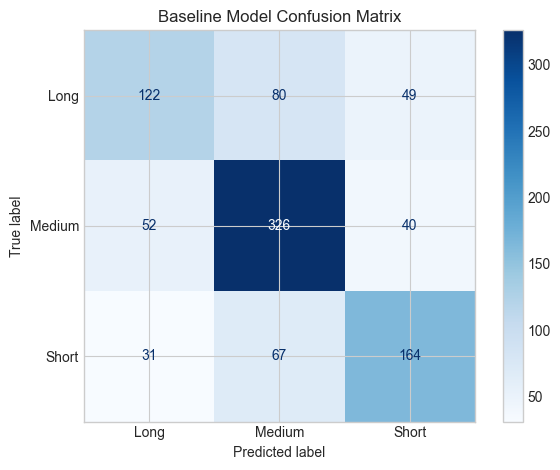

In [24]:
# TODO: Create and display the confusion matrix for baseline
#
# Steps:
# 1. Use confusion_matrix(y_test, baseline_preds) to create the matrix
# 2. Use ConfusionMatrixDisplay to visualize it
#
# Hint: ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# YOUR CODE HERE:

cm = confusion_matrix(y_test, baseline_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Baseline Model Confusion Matrix')
plt.tight_layout()
plt.show()

### Understanding the Confusion Matrix

The confusion matrix shows where your model gets predictions right and wrong:

- **Diagonal cells (top-left to bottom-right):** Correct predictions
- **Off-diagonal cells:** Misclassifications
- **Row:** What the actual class was
- **Column:** What the model predicted

**How to read it:** 
- If a row has many values spread across columns, that class is often confused with others
- If a column has many values from different rows, the model is predicting that class too often

**Example interpretation:**
- "20 Low samples were correctly predicted as Low"
- "5 Medium samples were incorrectly predicted as High"

### Baseline Interpretation

*Analyze your baseline results:*

**Questions to answer:**
- How well does the baseline perform?
- Which classes are easiest/hardest to predict (look at the diagonal)?
- Where does the model get confused (look at off-diagonal cells)?
- Is there overfitting (train vs test accuracy gap)?

**Your interpretation:**
- How well does the baseline perform?
The baseline performs moderately well, but not great. It’s clearly learning something, but there is room for improvement.

- Which classes are easiest/hardest to predict (look at the diagonal)?
Medium trips are the easiest to predict, while long trips are the hardest.

- Where does the model get confused (look at off-diagonal cells)?
The model often predicts Long trips as Medium (80 instances), indicating some difficulty in distinguishing between these two classes.

- Is there overfitting (train vs test accuracy gap)?
The model behaves similarly on unseen data, which is a good sign. There is no significant overfitting observed.

## Section 8: Cross-Validation

Cross-validation gives us a more robust estimate of model performance by training on different portions of the data.

In [25]:
# Cross-validation for key models
print("5-Fold Cross-Validation Results")
print("=" * 50)

models_to_cv = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

cv_results = []
for name, model in models_to_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_results.append({
        'Model': name,
        'CV Mean Accuracy': scores.mean(),
        'CV Std': scores.std()
    })
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)
cv_df

5-Fold Cross-Validation Results
Logistic Regression: 0.6731 (+/- 0.0389)
Random Forest: 0.8821 (+/- 0.0087)
Gradient Boosting: 0.8901 (+/- 0.0168)


,Model,CV Mean Accuracy,CV Std
0,Logistic Regression,0.673114,0.019429
1,Random Forest,0.882082,0.004346
2,Gradient Boosting,0.890139,0.008382


### Cross-Validation Interpretation

*What does the cross-validation tell you?*

- Which model is most consistent (lowest std)?
- Does the ranking change from the single train/test split?

**Your interpretation:**

The most consistent model is the Random Forest, which has the lowest standard deviation. However, Gradient Boosting has the highest mean accuracy, indicating it performs best on average across the folds; while showing similar standard deviation to Random Forest. 

- Does the ranking change from the single train/test split?
The reality is that the ranking does not change. Gradient Boosting still has the best accuracy while std keeps pretty similar to Random Forest. 

## Section 9: Model Iteration

In [26]:
# Store all results
all_results = [baseline_results]

# Dictionary to store trained models
trained_models = {
    'Logistic Regression (Baseline)': baseline_trained
}

### Model 2: Decision Tree

In [27]:
# TODO: Create and evaluate a Decision Tree classifier
#
# Create DecisionTreeClassifier(max_depth=10, random_state=42)
# Use evaluate_classifier() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_results, dt_trained, dt_preds = evaluate_classifier(dt_model, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree')

trained_models['DecisionTree'] = dt_trained
all_results.append(dt_results)

# Print results
print(f"Decision Tree - Test Accuracy: {dt_results['Test Accuracy']:.4f}, F1: {dt_results['F1 (weighted)']:.4f}")

Decision Tree - Test Accuracy: 0.8722, F1: 0.8713


### Model 3: Random Forest

In [28]:
# TODO: Create and evaluate a Random Forest classifier
#
# Create RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_results, rf_trained, rf_preds = evaluate_classifier(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, 'RandomForest')

trained_models['RandomForest'] = rf_trained
all_results.append(rf_results)

# Print results
print(f"Random Forest - Test Accuracy: {rf_results['Test Accuracy']:.4f}, F1: {rf_results['F1 (weighted)']:.4f}")

Random Forest - Test Accuracy: 0.8786, F1: 0.8770


### Model 4: K-Nearest Neighbors

In [29]:
# TODO: Create and evaluate a KNN classifier
#
# Create KNeighborsClassifier(n_neighbors=5)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_results, knn_trained, knn_preds = evaluate_classifier(knn_model, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN')

trained_models['KNN'] = knn_trained
all_results.append(knn_results)

# Print results
print(f"KNN - Test Accuracy: {knn_results['Test Accuracy']:.4f}, F1: {knn_results['F1 (weighted)']:.4f}")

KNN - Test Accuracy: 0.7905, F1: 0.7894


### Model 5: Gradient Boosting

In [30]:
# TODO: Create and evaluate a Gradient Boosting classifier
#
# Create GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb_results, gb_trained, gb_preds = evaluate_classifier(gb_model, X_train_scaled, X_test_scaled, y_train, y_test, 'GradientBoosting')

trained_models['GradientBoosting'] = gb_trained
all_results.append(gb_results)

# Print results
print(f"Gradient Boosting - Test Accuracy: {gb_results['Test Accuracy']:.4f}, F1: {gb_results['F1 (weighted)']:.4f}")

Gradient Boosting - Test Accuracy: 0.8894, F1: 0.8882


### Add Your Own Model (Optional)

Try a different model or different hyperparameters!

In [31]:
# YOUR ADDITIONAL MODEL HERE:
# Try SVC, different hyperparameters, or another classifier
svc_model = SVC(kernel='linear', C=1.0, random_state=42)
svc_results, svc_trained, svc_preds = evaluate_classifier(svc_model, X_train_scaled, X_test_scaled, y_train, y_test, 'SVC')

trained_models['SVC'] = svc_trained
all_results.append(svc_results)

# Print results
print(f"SVC - Test Accuracy: {svc_results['Test Accuracy']:.4f}, F1: {svc_results['F1 (weighted)']:.4f}")


SVC - Test Accuracy: 0.6627, F1: 0.6528


## Section 10: Model Comparison

In [32]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("Model Comparison:")
results_df

Model Comparison:


,Model,Train Accuracy,Test Accuracy,Precision (weighted),Recall (weighted),F1 (weighted)
4,GradientBoosting,0.9731,0.8894,0.8885,0.8894,0.8882
2,RandomForest,0.9280,0.8786,0.8789,0.8786,0.8770
1,DecisionTree,0.9326,0.8722,0.8716,0.8722,0.8713
3,KNN,0.8713,0.7905,0.7895,0.7905,0.7894
5,SVC,0.6712,0.6627,0.6607,0.6627,0.6528
0,LogisticRegression,0.6761,0.6574,0.6523,0.6574,0.6520


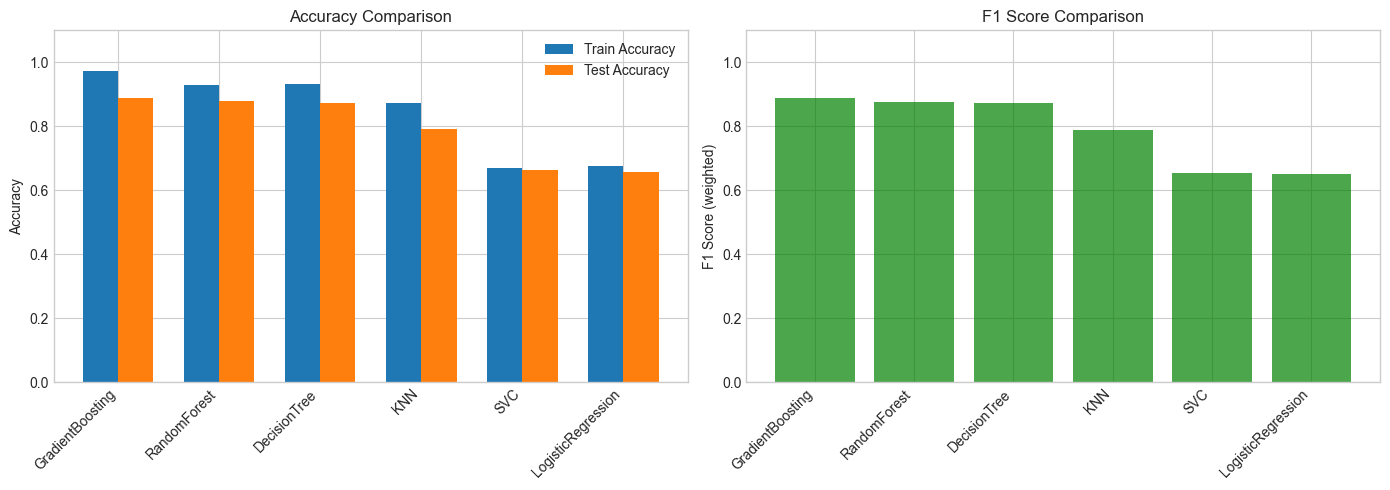

In [33]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = results_df['Model']
x = np.arange(len(models))
width = 0.35

# Accuracy comparison
axes[0].bar(x - width/2, results_df['Train Accuracy'], width, label='Train Accuracy')
axes[0].bar(x + width/2, results_df['Test Accuracy'], width, label='Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# F1 Score comparison
axes[1].bar(x, results_df['F1 (weighted)'], color='green', alpha=0.7)
axes[1].set_ylabel('F1 Score (weighted)')
axes[1].set_title('F1 Score Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Section 11: Best Model Selection

In [34]:
# Identify best model (by test accuracy)
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"F1 Score: {results_df.iloc[0]['F1 (weighted)']:.4f}")

Best Model: GradientBoosting
Test Accuracy: 0.8894
F1 Score: 0.8882


### Best Model Justification

*Explain why you chose this model:*
We chose Gradient Boosting because it has the best test accuracy.

**Questions to consider:**
- Why this model over others?
- Is there significant overfitting?
- How does it compare to baseline?
- Which metrics did you prioritize and why?

**Your justification:**

This model shows the best F1 score, which indicates it has a good balance of precision and recall. 

In general all models show no overfitting base on the Train vs Test accuracy, which is a good sign.

Compared to the baseline model, Gradient Boosting significantly improves performance, indicating that it effectively captures the underlying patterns in the data.

While evaluating overfitting, we we follow train/test metrics; also very importantly we look at F1 score, which is a good metric to evaluate the balance between precision and recall.

## Section 12: Best Model Analysis

In [35]:
# Get predictions from best model
y_pred = best_model.predict(X_test_scaled)

# Detailed classification report
print("Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Long       0.85      0.77      0.81       251
      Medium       0.86      0.90      0.88       418
       Short       0.97      0.99      0.98       262

    accuracy                           0.89       931
   macro avg       0.89      0.89      0.89       931
weighted avg       0.89      0.89      0.89       931



### Understanding the Classification Report

The classification report shows per-class metrics:

- **Precision:** Of all predictions for this class, what % were correct?
  - High precision = Few false positives
  - Example: "When the model predicts 'High', it's correct 85% of the time"

- **Recall:** Of all actual instances of this class, what % did we find?
  - High recall = Few false negatives
  - Example: "We correctly identified 90% of all actual 'High' cases"

- **F1-Score:** Harmonic mean of precision and recall (balanced measure)
  - Good when you need both precision and recall

- **Support:** Number of actual occurrences of each class in the test set

<Figure size 800x600 with 0 Axes>

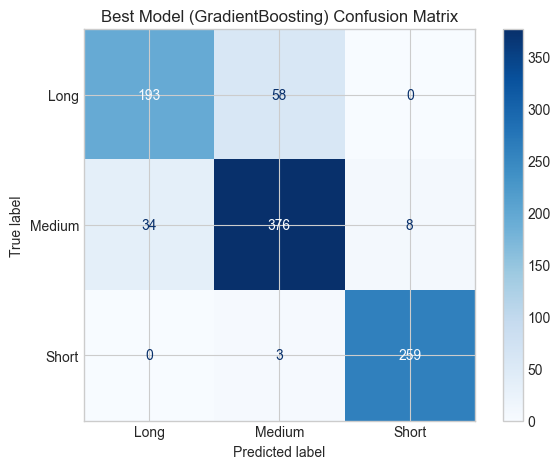

In [36]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Best Model ({best_model_name}) Confusion Matrix')
plt.tight_layout()
plt.show()

### Detailed Confusion Matrix Analysis

*Analyze the confusion matrix carefully:*

**For each class, describe:**
1. How many correct predictions (diagonal)?
2. What are the most common misclassifications?
3. Does the confusion make sense for your problem?

**Your analysis:**

The model most often confuses Medium with Long (34 cases), which makes sense because these two classes are adjacent in terms of trip duration, making it harder for the model to distinguish between them.

**How many correct predictions (diagonal)?**

Long - Long = 193

Medium - Medium = 376

Short - Short = 259

**What are the most common misclassifications?**

Long miscassified as Medium = 58

Medium miscassified as Long = 34

Other errors are very small.

**Does the confusion make sense for your problem?**
Yes, it makes sense. Long and Medium durations are likely closer in value and may share similar features (route, draft, speed, traffic conditions), so the model sometimes confuses them.


In [37]:
print("X columns:", len(X.columns))
print("importances:", len(best_model.feature_importances_))

X columns: 8
importances: 8


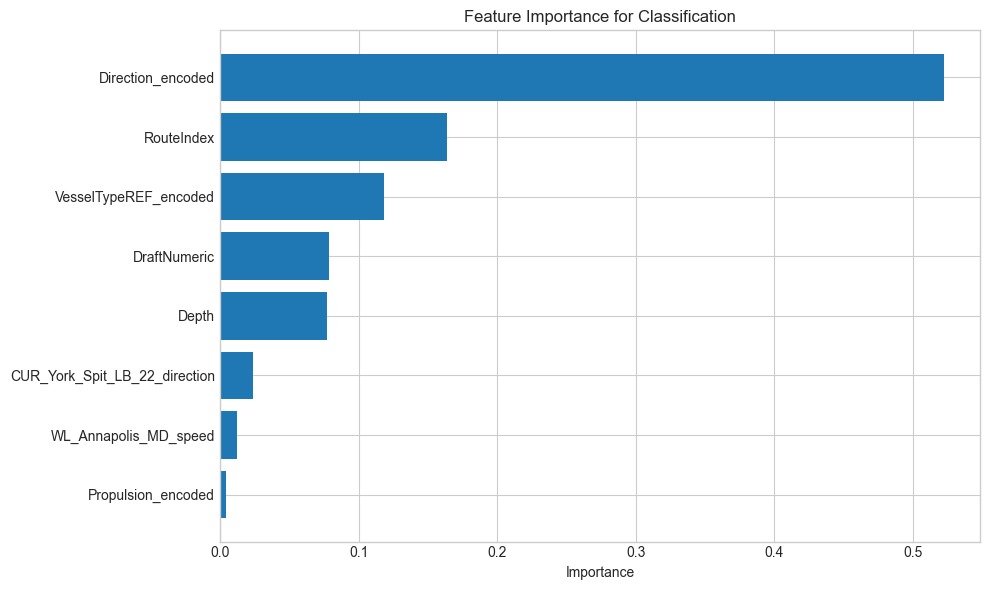


Top 5 most important features:
  Direction_encoded: 0.5222
  RouteIndex: 0.1641
  VesselTypeREF_encoded: 0.1181
  DraftNumeric: 0.0785
  Depth: 0.0770


In [38]:
# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 most important features:")
    for i, row in importance.tail(5).iloc[::-1].iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
        
elif hasattr(best_model, 'coef_'):
    # For multi-class, coef_ has shape (n_classes, n_features)
    coef = best_model.coef_
    if len(coef.shape) > 1:
        # Average absolute importance across classes
        importance_vals = np.abs(coef).mean(axis=0)
    else:
        importance_vals = np.abs(coef)
    
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance_vals
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Average Absolute Coefficient')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()

## Section 13: Model Iteration Reflection

*Reflect on your modeling process:*

**1. How did your models evolve from baseline to best?**

After moving to a tree-based model, we saw a significant improvement in performance. The baseline model had limited capacity to capture complex relationships, while the tree-based models (especially Gradient Boosting) were able to learn more intricate patterns in the data, leading to higher accuracy and better F1 scores.

**2. What surprised you about the results?**

The most surprising result was how much the Gradient Boosting model improved over the baseline. Obviously, we expected some improvement, but the significant jump in performance indicates that Gradient Boosting is particularly well-suited for this classification task.

**3. If you had more time, what would you try next?**

Maybe add more features improving our feature engineering; like for example adding day/night values or season information.
Also trying complete new sets of data.

## Section 14: Save Model and Artifacts

In [39]:
# Save the best classification model
model_path = '../models/classification_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler (fitted on SELECTED features)
scaler_path = '../models/classification_scaler.pkl'
joblib.dump(standard_scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the label encoder
encoder_path = '../models/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder saved to {encoder_path}")

# Save feature names (SELECTED_FEATURES)
features_path = '../models/classification_features.pkl'
joblib.dump(SELECTED_FEATURES, features_path)
print(f"Features saved to {features_path}")

# Save binning info (for reference in Streamlit app)
binning_info = {
    'bins': bins,
    'labels': labels,
    'original_target': ORIGINAL_TARGET
}
binning_path = '../models/binning_info.pkl'
joblib.dump(binning_info, binning_path)
print(f"Binning info saved to {binning_path}")

Model saved to ../models/classification_model.pkl
Scaler saved to ../models/classification_scaler.pkl
Label encoder saved to ../models/label_encoder.pkl
Features saved to ../models/classification_features.pkl
Binning info saved to ../models/binning_info.pkl


In [40]:
# Verify saved model works
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_encoder = joblib.load(encoder_path)

# Test prediction
test_sample = X_test.iloc[[0]]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_pred = loaded_model.predict(test_sample_scaled)
test_pred_label = loaded_encoder.inverse_transform(test_pred)

print(f"\nModel verification:")
print(f"Sample input: {test_sample.values[0][:3]}...")
print(f"Predicted class: {test_pred_label[0]}")
print(f"Actual class: {loaded_encoder.inverse_transform([y_test[0]])[0]}")
print("\nModel saved and verified successfully!")


Model verification:
Sample input: [118.        3.       28.58333]...
Predicted class: Medium
Actual class: Medium

Model saved and verified successfully!


---

## Summary

### What You Accomplished
- [ ] Created binned target variable with justification
- [ ] Verified class balance
- [ ] Used consistent features (same as regression or justified different)
- [ ] Split data with stratification
- [ ] Performed cross-validation
- [ ] Built baseline classifier
- [ ] Tried multiple classifier types
- [ ] Compared and selected best model
- [ ] Analyzed model with confusion matrix and classification report
- [ ] Saved model, scaler, encoder, and binning info

### Key Results



GradientBoosting	0.9731	0.8894	0.8885	0.8894	0.8882
2	RandomForest	0.9280	0.8786	0.8789	0.8786	0.8770
1	DecisionTree	0.9326	0.8722	0.8716	0.8722	0.8713
3	KNN	0.8713	0.7905	0.7895	0.7905	0.7894
5	SVC	0.6712	0.6627	0.6607	0.6627	0.6528
0	LogisticRegression	0.6761	0.6574	0.6523	0.6574	0.6520



**Best Model:** GradientBoosting

**Test Accuracy:** 0.8894

**F1 Score:** 0.8882

**Improvement over baseline:** We went from 0.6574 to 0.8894, which is a significant improvement, indicating that our model is much better at capturing the underlying patterns in the data.

### Comparison to Regression

*How does classification performance relate to your regression results?*
Classification performance is consistent with the regression results. It just makes sense because we are using the same features and the same underlying data patterns. The main difference is that classification focuses on categorizing trips into discrete bins, while regression predicted exact trip durations with is more challenging.

[Write your comparison here - consider: Are the same features important? Does predicting categories work better/worse than predicting exact values for your problem?]

The most important features are largely the same in both regression and classification models. Direction and RouteIndex consistently have the strongest impact, showing that route path and travel direction are the main drivers of transit duration.

However, predicting categories (Short, Medium, Long) works better than predicting exact duration values. The classification model achieves much higher performance and more stable results, while the regression model struggles with variability in exact minutes.

This suggests that while the model can reliably distinguish between duration ranges, predicting precise transit time is more difficult due to natural fluctuations in real-world conditions.



---

## Next Steps

Move on to building your **Streamlit app** to deploy both models!

You now have saved:
- `regression_model.pkl` and `regression_scaler.pkl`
- `classification_model.pkl`, `classification_scaler.pkl`, and `label_encoder.pkl`

The Streamlit starter code in `app/app.py` will load these files.

---

## Checkpoint 4 Submission Instructions

You've completed the classification model. Time to submit!

### Step 1: Save and Close
Make sure this notebook is saved and all cells have been run.

### Step 2: Commit Your Work
```bash
git add .
git commit -m "Complete classification model - Checkpoint 4"
git push
```

### Step 3: Submit to Canvas
1. Go to Canvas
2. Find the **Checkpoint 4: Classification Model** assignment
3. Submit the link to your GitHub repository

### What Gets Graded
- Binning justification and implementation
- Feature consistency (same as regression or justified different)
- Model comparison and selection reasoning
- Confusion matrix interpretation
- Classification report analysis
- All written reflections completed

---